<a href="https://colab.research.google.com/github/Isafon/ECE528/blob/main/ECE528_ASN2_Q2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Q2 Part B ECE528 LA2 - Isa Fontana



## Setup & Imports

In [1]:
import os, time, random, numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.plugins.hparams import api as hp

SEED = 0
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__, "| Keras:", keras.__version__)

TF: 2.19.0 | Keras: 3.10.0


## Load, Split, Normalize (As per usual)

In [2]:
# Same ol' same ol'
# We been here before, loading model, spliting it, then normalizing it
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

val_size = 10_000
x_val, y_val   = x_train[-val_size:], y_train[-val_size:]
x_train, y_train = x_train[:-val_size], y_train[:-val_size]

x_train = (x_train.astype("float32")/255.0)[..., None]
x_val   = (x_val.astype("float32")/255.0)[..., None]
x_test  = (x_test.astype("float32")/255.0)[..., None]

x_train.shape, x_val.shape, x_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1))

## Helpers

In [8]:
def make_act(name: str):
    name = name.lower()
    if name == "relu":
        return keras.layers.ReLU()
    if name == "leakyrelu":
        return keras.layers.LeakyReLU(negative_slope=0.1)   # Keras 3 arg
    if name == "gelu":
        # Works across TF/Keras versions
        return keras.layers.Activation(tf.nn.gelu)  # or keras.activations.gelu
    raise ValueError(name)

def build_model_with_acts(act_conv: str, act_dense: str):
    ActConv  = make_act(act_conv)
    ActDense = make_act(act_dense)

    # LAYERSS!
    inp = keras.layers.Input((28,28,1))
    x = keras.layers.Conv2D(32, 3, padding="same")(inp)
    x = keras.layers.ReLU()(x)                 # fixed
    x = keras.layers.MaxPooling2D()(x)

    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = ActConv(x)                             # swept
    x = keras.layers.MaxPooling2D()(x)

    x = keras.layers.Conv2D(128, 3, padding="same")(x)
    x = keras.layers.ReLU()(x)                 # fixed
    x = keras.layers.MaxPooling2D()(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.30)(x)

    x = keras.layers.Dense(128)(x)
    x = ActDense(x)

    out = keras.layers.Dense(10, activation="softmax")(x)
    return keras.Model(inp, out, name=f"q2b_{act_conv}_{act_dense}")

## HParams space, RMSprop optimizer, and training loop

In [9]:
HP_ACT_CONV  = hp.HParam("act_conv",  hp.Discrete(["relu", "leakyrelu", "gelu"]))
HP_ACT_DENSE = hp.HParam("act_dense", hp.Discrete(["relu", "leakyrelu", "gelu"]))
METRIC_VAL_ACC = "val_accuracy"

logdir_root = os.path.join("logs", "q2b_hparams", time.strftime("%Y-%m-%d_%H-%M-%S"))
os.makedirs(logdir_root, exist_ok=True)
with tf.summary.create_file_writer(logdir_root).as_default():
    hp.hparams_config(hparams=[HP_ACT_CONV, HP_ACT_DENSE],
                      metrics=[hp.Metric(METRIC_VAL_ACC, display_name="Val Accuracy")])

def run_trial(act_conv, act_dense, *, lr=1e-3, epochs=12, batch=128):
    model = build_model_with_acts(act_conv, act_dense)

    # pick winner from Q2(a): RMSprop (could be changed to adamw if you're feeling fancy)
    opt = keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    callbacks = [
        hp.KerasCallback(os.path.join(logdir_root, f"conv-{act_conv}_dense-{act_dense}"),
                         {HP_ACT_CONV: act_conv, HP_ACT_DENSE: act_dense}),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5),
    ]
    model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=epochs, batch_size=batch, callbacks=callbacks, verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return model, float(test_acc)

## Grid search over 9 activation pairs

In [10]:
acts = ["relu", "leakyrelu", "gelu"]
results = []
for a_conv in acts:
    for a_dense in acts:
        print(f"=== Trial: conv={a_conv}, dense={a_dense} ===")
        model, acc = run_trial(a_conv, a_dense)
        results.append({"act_conv": a_conv, "act_dense": a_dense, "test_acc": acc, "model": model})

df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
df

=== Trial: conv=relu, dense=relu ===
Epoch 1/12
391/391 - 7s - 19ms/step - accuracy: 0.7659 - loss: 0.6277 - val_accuracy: 0.8591 - val_loss: 0.3876 - learning_rate: 1.0000e-03
Epoch 2/12
391/391 - 1s - 3ms/step - accuracy: 0.8673 - loss: 0.3641 - val_accuracy: 0.8833 - val_loss: 0.3128 - learning_rate: 1.0000e-03
Epoch 3/12
391/391 - 1s - 3ms/step - accuracy: 0.8883 - loss: 0.3073 - val_accuracy: 0.8975 - val_loss: 0.2772 - learning_rate: 1.0000e-03
Epoch 4/12
391/391 - 1s - 3ms/step - accuracy: 0.9004 - loss: 0.2736 - val_accuracy: 0.9027 - val_loss: 0.2655 - learning_rate: 1.0000e-03
Epoch 5/12
391/391 - 1s - 3ms/step - accuracy: 0.9081 - loss: 0.2469 - val_accuracy: 0.9014 - val_loss: 0.2580 - learning_rate: 1.0000e-03
Epoch 6/12
391/391 - 1s - 3ms/step - accuracy: 0.9150 - loss: 0.2305 - val_accuracy: 0.9157 - val_loss: 0.2337 - learning_rate: 1.0000e-03
Epoch 7/12
391/391 - 1s - 3ms/step - accuracy: 0.9232 - loss: 0.2093 - val_accuracy: 0.9099 - val_loss: 0.2400 - learning_rate: 

,act_conv,act_dense,test_acc,model
0,gelu,gelu,0.9211,"<Functional name=q2b_gelu_gelu, built=True>"
1,leakyrelu,gelu,0.9210,"<Functional name=q2b_leakyrelu_gelu, built=True>"
2,gelu,relu,0.9204,"<Functional name=q2b_gelu_relu, built=True>"
3,leakyrelu,leakyrelu,0.9177,"<Functional name=q2b_leakyrelu_leakyrelu, buil..."
4,leakyrelu,relu,0.9168,"<Functional name=q2b_leakyrelu_relu, built=True>"
5,relu,relu,0.9163,"<Functional name=q2b_relu_relu, built=True>"
6,gelu,leakyrelu,0.9163,"<Functional name=q2b_gelu_leakyrelu, built=True>"
7,relu,gelu,0.9157,"<Functional name=q2b_relu_gelu, built=True>"
8,relu,leakyrelu,0.9149,"<Functional name=q2b_relu_leakyrelu, built=True>"


from matplotlib import pyplot as plt
df['test_acc'].plot(kind='hist', bins=20, title='test_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('act_conv').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('act_dense').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['test_acc'].plot(kind='line', figsize=(8, 4), title='test_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['act_dense'].value_counts()
    for x_label, grp in df.groupby('act_conv')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('act_conv')
_ = plt.ylabel('act_dense')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['act_conv'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='test_acc', y='act_conv', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['act_dense'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='test_acc', y='act_dense', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Export Best Model

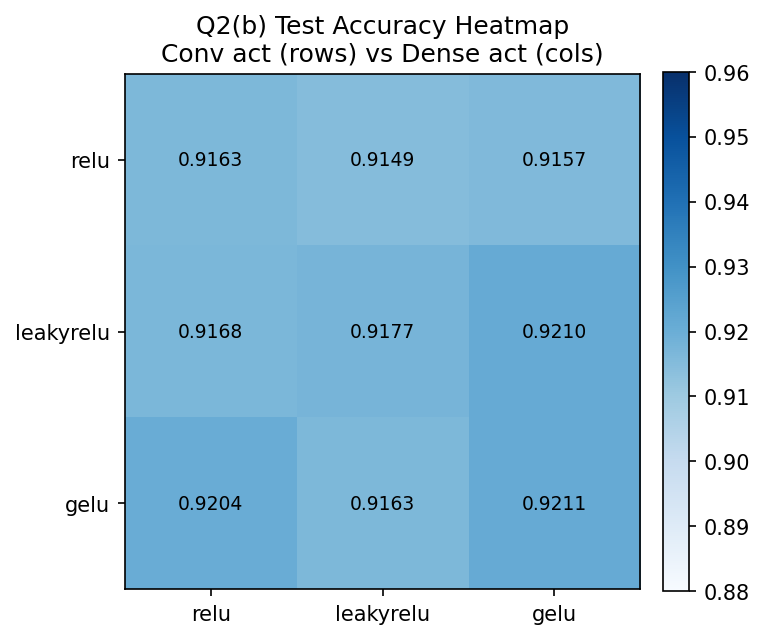

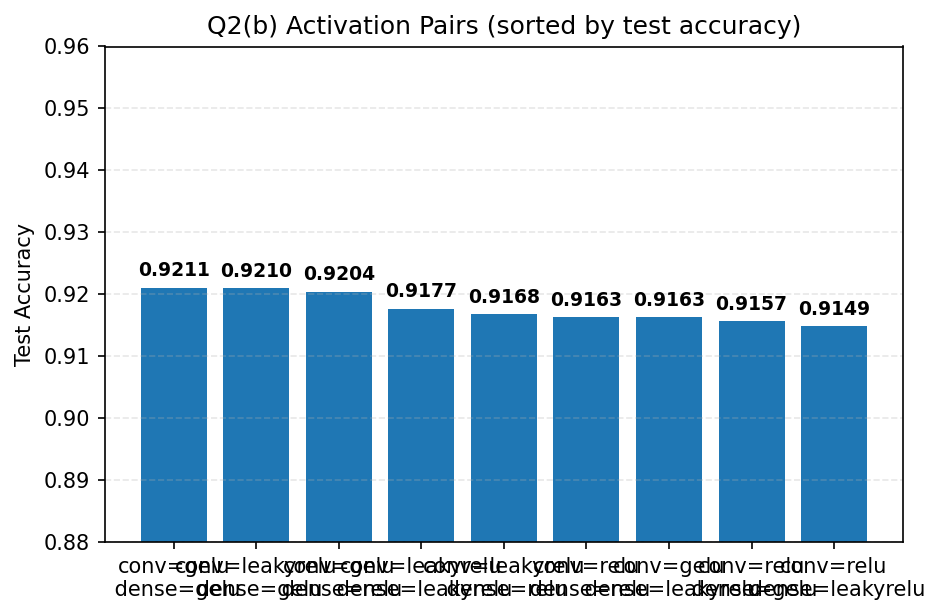

BEST: Conv act=gelu, Dense act=gelu, Test Acc=0.9211


In [11]:
os.makedirs("figs_q2b", exist_ok=True)

# Heat that map
heat = df.pivot(index="act_conv", columns="act_dense", values="test_acc").reindex(index=acts, columns=acts)
plt.figure(figsize=(5.2,4.8), dpi=150)
im = plt.imshow(heat.values, cmap="Blues", vmin=0.88, vmax=0.96)
plt.xticks(range(3), acts); plt.yticks(range(3), acts)
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{heat.values[i,j]:.4f}", ha="center", va="center", fontsize=9)
plt.title("Q2(b) Test Accuracy Heatmap\nConv act (rows) vs Dense act (cols)")
plt.colorbar(im, fraction=0.046, pad=0.04); plt.tight_layout()
plt.savefig("figs_q2b/q2b_heatmap.png"); plt.show()

# Sort those bars
plt.figure(figsize=(6.4,4.2), dpi=150)
labels = [f"conv={r['act_conv']}\n dense={r['act_dense']}" for _, r in df.iterrows()]
vals   = df["test_acc"].values
bars = plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), labels)
plt.ylim(0.88, 0.96); plt.ylabel("Test Accuracy")
plt.title("Q2(b) Activation Pairs (sorted by test accuracy)")
for i, v in enumerate(vals):
    plt.text(i, v+0.0012, f"{v:.4f}", ha="center", va="bottom", fontsize=9, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.3); plt.tight_layout()
plt.savefig("figs_q2b/q2b_bar_sorted.png"); plt.show()

df.to_csv("figs_q2b/q2b_results.csv", index=False)

# Winner (chicken dinner !!) summary
best = df.iloc[0]
print(f"BEST: Conv act={best['act_conv']}, Dense act={best['act_dense']}, Test Acc={best['test_acc']:.4f}")